In [4]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sys import argv
import numpy as np
import math
from tqdm import tqdm_notebook
import datetime
from sys import exit

In [5]:
## Variables --
train_path = 'bank_dataset/bank_train.csv'
test_path = 'bank_dataset/bank_test.csv'
validate_path = 'bank_dataset/bank_val.csv'

train_path = argv[1]
test_path  = argv[2]
validate_path = argv[3]
part = argv[4]
print('train path', train_path)

In [6]:
def read_data(path):
    df = pd.read_csv(path, sep=';')
    return df

In [7]:
train_data = read_data(train_path)
# train_data.head()

In [8]:
# print(train_data.shape)

In [9]:
#train_data.plot(subplots = True, figsize = (10,20))

In [10]:
# for col in train_data.columns:
#     if col == 'balance' or col == 'duration':
#         continue
#     print('For col:',col)
#     print(set(train_data[col].values))

In [11]:
ohe_columns = {}
binary_columns = ['default', 'housing', 'loan']
def make_one_hot_encoding(data, cols):
    Y = data['y']
    data.drop('y', axis = 'columns', inplace = True)
    for col in cols:
        append_data = pd.get_dummies(data[col])
        ohe_columns[col] = append_data.columns
        for new_col in append_data.columns:
            data[col +'.'+ str(new_col)] = append_data[new_col]
        data.drop(col, axis = 'columns', inplace = True)
    data['y'] = Y
    for b_col in binary_columns:
        data[b_col] = data[b_col] == 'yes'
    return data

def apply_one_hot_encoding(data, cols):
    Y = data['y']
    data.drop('y', axis = 'columns', inplace = True)
    for col in cols:
        for new_col in ohe_columns[col]:
            data[col + '.' + str(new_col)] = data[col] == new_col
        data.drop(col, axis = 'columns', inplace = True)
    data['y'] = Y
    for b_col in binary_columns:
        data[b_col] = data[b_col] == 'yes'
    return data
        

In [12]:
# ohe_test_data.head()

In [13]:
# ohe_test_data.loc[ohe_test_data['age'] == 34, 'age']
# ohe_test_data['age.35'] = ohe_test_data['age'] == 34

In [14]:
# ohe_test_data

### Main reading starts from here -

In [15]:
##Read data and make one hot vectors
train_data = read_data(train_path)
n_categorical_cols = ['job', 'marital', 'education', 'contact', 'month', 'campaign', 'poutcome']
#print('non categorical or biary cols',set(train_data.columns) - set(n_categorical_cols))
std_train_data = train_data.copy(deep=True)

ohe_train_data = make_one_hot_encoding(train_data, n_categorical_cols)
ohe_train_data.loc[ohe_train_data['pdays'] == -1, 'pdays'] = 999
#print(std_train_data.shape)
#print(ohe_train_data.shape)
#ohe_train_data.head()

non categorical or biary cols {'default', 'day', 'pdays', 'age', 'previous', 'loan', 'y', 'housing', 'balance', 'duration'}
(36168, 17)
(36168, 95)


,age,default,balance,housing,loan,day,duration,pdays,previous,job.admin.,...,campaign.50,campaign.51,campaign.55,campaign.58,campaign.63,poutcome.failure,poutcome.other,poutcome.success,poutcome.unknown,y
0,57,False,890,False,False,5,343,999,0,0,...,0,0,0,0,0,0,0,0,1,no
1,56,False,2558,False,False,19,288,999,0,0,...,0,0,0,0,0,0,0,0,1,no
2,50,False,267,True,False,21,30,999,0,0,...,0,0,0,0,0,0,0,0,1,no
3,47,False,4567,False,False,31,921,999,0,0,...,0,0,0,0,0,0,0,0,1,no
4,49,False,5887,False,False,2,181,293,2,0,...,0,0,0,0,0,1,0,0,0,yes


In [16]:
test_data = read_data(test_path)
vali_data = read_data(validate_path)
std_test_data = test_data.copy(deep=True)
std_vali_data = vali_data.copy(deep=True)

ohe_test_data = apply_one_hot_encoding(test_data, n_categorical_cols)
ohe_test_data.loc[ohe_test_data['pdays'] == -1, 'pdays'] = 999
ohe_vali_data = apply_one_hot_encoding(vali_data, n_categorical_cols)
ohe_vali_data.loc[ohe_vali_data['pdays'] == -1, 'pdays'] = 999

print('test std shape       :',std_test_data.shape)
print('test ohe shape       :',ohe_test_data.shape)
print('validation std shape :',std_vali_data.shape)
print('validation ohe shape :',ohe_vali_data.shape)


test std shape       : (4521, 17)
test ohe shape       : (4521, 95)
validation std shape : (4522, 17)
validation ohe shape : (4522, 95)


### Changing numerical columns

In [17]:
numerical_cols = ['age', 'balance', 'day', 'duration','pdays', 'previous']
# data_medians = ohe_train_data[numerical_cols].median(axis = 0)
# for col in numerical_cols:
#     train_data[col] = ohe_train_data[col] > data_medians[col]
# ohe_train_data.head()

In [18]:
# numerical_cols = ['age', 'balance', 'day', 'duration','pdays', 'previous']
# medians = train_data[numerical_cols].median(axis=0)
# print(medians)

In [19]:
# # Not useful
# # Delete it
# def split_on_median(data, col):
#     med = np.median(data[col])
#     print('\n\nmedian', med)
#     #data[data[col] > med]
#     data.loc[:,col] = data.loc[:,col] > med
#     return data, med

In [20]:
def entropy(data):
    m = data.shape[0]
    negative_data = data[data['y'] == 'no'].shape[0]
    positive_data = data[data['y'] == 'yes'].shape[0]
    if negative_data == 0 or positive_data == 0:
        return 0
    ent = (positive_data/m)*np.log2(m/positive_data) + (negative_data/m)*np.log2(m/negative_data)
    return ent
# entropy(ohe_train_data)

In [21]:
std_col_val_set = {}
for col in std_train_data.columns:
    if col in numerical_cols:
        std_col_val_set[col] = [True, False]
    else:
        std_col_val_set[col] = list(set(std_train_data[col].values))
# print('normal col values')
# print(std_col_val_set)

ohe_col_val_set = {}
for col in ohe_train_data.columns:
    if col in numerical_cols:
        ohe_col_val_set[col] = [True, False]
    else:
        ohe_col_val_set[col] = list(set(ohe_train_data[col].values))
# print('Ohe encoded col values')
# print(ohe_col_val_set)

In [22]:
def inf_gain(attr, data):
    m = data.shape[0]
    if m == 0:
        return 0
    uniq_values = None
    col_median = None
    if attr in numerical_cols:
        col_median = data[attr].median()
        uniq_values = [True, False]
    else:
        uniq_values = col_val_set[attr]
    Hs = []
    for val in uniq_values:
        sub_data = None
        if attr in numerical_cols and val:
            sub_data = data[data[attr] > col_median]
        elif attr in numerical_cols and not val:
            sub_data = data[data[attr] <= col_median]
        else:
            sub_data = data[data[attr] == val]
        if sub_data.shape[0] == 0:
            continue
        en = entropy(sub_data)
        prob = sub_data.shape[0]/m
        Hs.append(prob*en)
    return np.sum(Hs)

In [23]:
def best_attr_split(data):
    if data.shape[0] == 0:
        return None, 0
    #print('best attr data',data.shape)
    max_ig = 0
    best_attr = None
    H_y = entropy(data)
    #print('entropy of dataset', H_y)
    for col in data.columns[:-1]:
        ig = H_y - inf_gain(col, data)
        #print('Col: %-20s info gain: %f'%(col,ig))
        if max_ig < ig:
            max_ig = ig
            best_attr = col
    return best_attr, max_ig
# print(ohe_train_data[0:15])

#col_val_set = ohe_col_val_set
# best_attr_split(ohe_train_data[:20])

In [24]:
class Node:
    total_nodes = 0
    def  __init__(self, parent, val=-1, childs = [], attr = None, split_val_parent= None, median = None):
        self.parent = parent
        self.val = val
        self.childs = childs
        self.sub_tree_size = 0
        self.attr = attr
        self.split_val_p = split_val_parent
        self.median = median
        self.prune_below = False
        self.pruning_checked = False
        Node.total_nodes += 1
    
    def __str__(self):
        l = len(self.childs)
        return 'attr:%-10s, val:%-10s, pruned?:%-5d,p_checked:%d ,#childs:%-5d'%(self.attr,str(self.val),self.prune_below,self.pruning_checked,l)

In [25]:
# std_train_data.head(15)

In [26]:
# Make Decision tree
class DecisionTree():
    def __init__(self, max_depth=20):
        self.max_depth = max_depth
        self.prediction_at_depth = []
    
    def build_tree(self, data, parent = None):
        # print('data ------------',data.shape)
        median = None
        if data.shape[0] == 0:
            return None
        Y_uniq_vals_len = len(list(set(data['y'].values)))
        y_val = data['y'].mode()[0]
        if Y_uniq_vals_len <=1:
            return Node(parent = parent, val = y_val, childs = [], attr='leaf')
        split_attr, max_ig = best_attr_split(data)
        if split_attr == None:
            print('\n\n no values to split')
            #print(data.shape)
            #print(data)
            return Node(parent = parent, val = y_val, childs = [], attr='leaf')
        if max_ig < 0:
            print('\n\n negative ig max')
            #print(data.shape)
            #print(data)
            return None

        if split_attr in numerical_cols:
            median = data[split_attr].median()
        
        values_to_split = col_val_set[split_attr]

        node = Node(parent=parent,val=y_val,childs=[],attr=split_attr, median=median)
        node.sub_tree_size = 1
        # print('Attr:',split_attr)
        for split_val in values_to_split:
            # If and elif --it's a numirical attribute, els -- for categorical
            # print('split value:',split_val)
            if median != None and split_val == True:
                # print('more than median')
                # print('median',median)
                child = self.build_tree(data[data[split_attr] > median], node)
            elif median != None and split_val == False:
                # print('less then median')
                child = self.build_tree(data[data[split_attr] <= median], node)
            else:
                # print('no categorical')
                child = self.build_tree(data[data[split_attr] == split_val], node)
            
            if child != None:
                child.split_val_p = split_val
                node.childs.append(child)
                node.sub_tree_size += child.sub_tree_size
        # print('returning for node',node)
        return node
    
    def predict_a_point(self, row, node, depth = 0, max_depth = 50, consider_pruning = False, prune_it = False):
        #print('For row  :',row.head())
        if node == None:
            print("\n\n\nNode became none-----------------------------")
            return 0
        if 'y' in row:
            pred = 1 if node.val == row['y'] else 0
            self.prediction_at_depth.append(pred)
            
        if consider_pruning and node.prune_below:
            return node.val
        
        if len(node.childs) < 1 or node.attr == 'leaf' or depth >= max_depth:
            return node.val
        attribute = node.attr
        # print('Attribute : %s'%(attribute))
    #     print('node      : %s'%(node))
        if attribute in numerical_cols:
    #         print('\tnumerical attr')
    #         print('\trows attr value : %-10s'%str(row[attribute]))
            if row[attribute] > node.median:
                return self.predict_a_point(row, node.childs[0], depth+1, max_depth, consider_pruning, prune_it)
            else:
                return self.predict_a_point(row, node.childs[1], depth+1, max_depth, consider_pruning, prune_it)
        else:
    #         print('\tnon-numerical attr')
            for child in node.childs:
    #             print('No. childs:',len(node.childs))
    #             print('\tChild:',child)
                if row[attribute] == child.split_val_p:
                    return self.predict_a_point(row, child, depth+1, max_depth, consider_pruning, prune_it)
        #print('New Attribute val found ----------------------------')
        #print('suggested value by node:', node.val)
        return node.val
    
    def predict(self,tree, data, consider_pruning = False):
        predictions = []
        depth_wise_predictions = []
        max_depth_pred = 0
        for index, row in data.iterrows():
            self.prediction_at_depth = []
            predictions.append(self.predict_a_point(row, tree, consider_pruning=consider_pruning))
            
            if len(self.prediction_at_depth) > max_depth_pred:
                max_depth_pred = len(self.prediction_at_depth)
            
            depth_wise_predictions.append(self.prediction_at_depth)
        
        depth_pred = np.zeros((len(depth_wise_predictions), max_depth_pred))
        for i in range(depth_pred.shape[0]):
            for j in range(depth_pred.shape[1]):
                if len(depth_wise_predictions[i]) > j:
                    depth_pred[i,j] = depth_wise_predictions[i][j]
                else:
                    depth_pred[i,j] = depth_pred[i,j-1]
                #print(depth_pred[i,j], end = ' ')
            #print()
        depth_wise_predictions = [0]*max_depth_pred
        for d in range(max_depth_pred):
            depth_wise_predictions[d] = sum(depth_pred[:,d])*100/data.shape[0]

        return predictions, depth_wise_predictions
    
    def set_prune_values(self, row, node, depth = 0, max_depth = 50, prune_it = False):
        #print('For row  :',row.head())
        if node == None:
            print("\n\n\nNode became none-----------------------------")
            return 0
        pred = 1 if node.val == row['y'] else 0
        self.prediction_at_depth.append(pred)
        
        if pred == 1 and not node.pruning_checked:
            #print('pruning')
            node.prune_below = True
            #print('\t',node)
            return node.val
        
        else:
            #print('rem prune')
            node.prune_below = False
            node.pruning_checked = True
        
        if len(node.childs)<1 or node.attr == 'leaf' or depth >= max_depth:
            return node.val
        
        attribute = node.attr
        
        # print('Attribute : %s'%(attribute))
    #     print('node      : %s'%(node))
        if attribute in numerical_cols:
    #         print('\tnumerical attr')
    #         print('\trows attr value : %-10s'%str(row[attribute]))
            if row[attribute] > node.median:
                return self.set_prune_values(row, node.childs[0], depth+1, max_depth)
            else:
                return self.set_prune_values(row, node.childs[1], depth+1, max_depth)
        else:
    #         print('\tnon-numerical attr')
            for child in node.childs:
    #             print('No. childs:',len(node.childs))
    #             print('\tChild:',child)
                if row[attribute] == child.split_val_p:
                    return self.set_prune_values(row, child, depth+1, max_depth)
        
        #print('New Attribute val found ----------------------------')
        return node.val
    
    def dfs_tree(self, node, d =0):
        if node != None:
            if node.prune_below == True and node.attr != 'leaf':
                print('pruned node at depth:%d'%(d))
                print(node)
        for child in node.childs:
            self.dfs_tree(child, d+1)
        return None
    
    ## Reduced Error Pruning -->
    def prune_tree(self, tree, data):
        predictions = []
        for index, row in data.iterrows():
            predictions.append(self.set_prune_values(row, tree))
        print('pruning done')
        return predictions
    
    def count_depth(self, node, d = 0,node_count=0, count_pruned = True):
        d_s = [d]
        node_count +=1
        if node.prune_below and not count_pruned:
            return d
        for child in node.childs:
            d_local = self.count_depth(child, d+1, node_count, count_pruned)
            d_s.append(d_local)
        return np.max(d_s)
        

In [27]:
import warnings
warnings.filterwarnings('ignore')

### Global Variables --

In [28]:
col_val_set = {}
std_tree_root = None
ohe_tree_root = None

### Exec to make decision Tree

In [45]:
## Standard split for each uniq categorical values
# part = 'a'
if part == 'a' or part == 'b':
    t1 = datetime.datetime.now()
    d_tree = DecisionTree()
    col_val_set = std_col_val_set
    std_tree_root = d_tree.build_tree(std_train_data[:])
    t2 = datetime.datetime.now()
    print('time taken',t2-t1)
    
    node_count =0
    def count_depth(node, d = 0, count_pruned = True):
        d_s = [d]
        global node_count
        node_count +=1
        if node.prune_below and not count_pruned:
            return d
        for child in node.childs:
            d_local = count_depth(child, d+1, count_pruned)
            d_s.append(d_local)
        return np.max(d_s)

    l_depth = count_depth(std_tree_root, count_pruned=False)
    print('Node Count:',node_count,'Depth:', l_depth)

time taken 0:00:00.092396
Node Count: 3 Depth: 1


In [33]:
if part =='a' or part == 'b':
    t1 = datetime.datetime.now()
    d_tree = DecisionTree()
    col_val_set = ohe_col_val_set
    ohe_tree_root = d_tree.build_tree(ohe_train_data[:])
    t2 = datetime.datetime.now()
    print('time taken',t2-t1)

time taken 0:00:00.158346


### Prediction for train, test and validation set

For Normal(non ohe) train: [88.35987613359876, 78.69110816191107]
For Ohe Train: [88.35987613359876, 78.69110816191107]
test accuracy       : [87.52488387524883, 77.2174297721743]
test accuracy       : [87.52488387524883, 77.2174297721743]
validatoin accuracy : [88.61123396727112, 77.90800530738612]


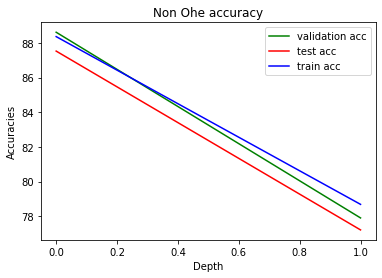

validatoin accuracy : [88.61123396727112, 77.90800530738612]


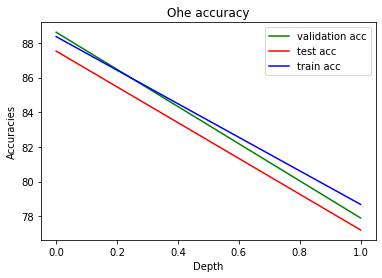

In [35]:
if part == 'a':
    _, std_train_acc = d_tree.predict(std_tree_root, std_train_data[:])
    print('For Normal(non ohe) train:',std_train_acc)

    _, ohe_train_acc = d_tree.predict(ohe_tree_root, ohe_train_data[:])
    print('For Ohe Train:',ohe_train_acc)

    _, test_acc = d_tree.predict(std_tree_root, std_test_data[:])
    print('std test accuracy       :',test_acc)
    
    _, ohe_test_acc = d_tree.predict(ohe_tree_root, ohe_test_data[:])
    print('ohe test accuracy       :',ohe_test_acc)
    
    _, std_vali_acc = d_tree.predict(std_tree_root, std_vali_data[:])
    print('std validatoin accuracy :', std_vali_acc)
    
    _, ohe_vali_acc = d_tree.predict(ohe_tree_root, ohe_vali_data[:])
    print('ohe validatoin accuracy :',ohe_vali_acc)
    
    fig = plt.figure()
    plt.plot(std_vali_acc, 'g', label = 'validation acc')
    plt.plot(test_acc, '-r', label = 'test acc')
    plt.plot(std_train_acc,'-b', label = 'train acc')
    plt.title("Non Ohe accuracy")
    plt.xlabel("Depth")
    plt.ylabel("Accuracies")
    plt.legend()
    #plt.show()
    fig.savefig("Non_ohe_accuracy_all.png")
    
    fig = plt.figure()
    plt.plot(ohe_vali_acc, '-g', label = 'validation acc')
    plt.plot(ohe_test_acc, '-r', label = 'test acc')
    plt.plot(ohe_train_acc, '-b', label = 'train acc')
    plt.title("Ohe accuracy")
    plt.xlabel("Depth")
    plt.ylabel("Accuracies")
    plt.legend()
    #plt.show()
    fig.savefig("part_a_Ohe_accuracy_all.png")

test accuracy       : [87.52488387524883, 77.2174297721743]


NameError: name 'std_train_acc' is not defined

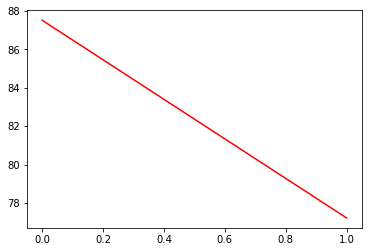

In [34]:

# _, test_acc = d_tree.predict(std_tree_root, std_test_data[:])
# print('test accuracy       :',test_acc)
# fig = plt.figure()
# plt.plot(test_acc, '-r', label = 'test acc')
# plt.plot(std_train_acc,'-b', label = 'train acc')
# plt.title("Non ohe test accuracy")
# plt.xlabel("Depth")
# plt.ylabel("Accuracies")
# plt.legend()
# plt.show()
# #fig.savefig("Non_ohe_test_accuracy.png")

# _, ohe_test_acc = d_tree.predict(ohe_tree_root, ohe_test_data[:])
# print('test accuracy       :',ohe_test_acc)
# fig = plt.figure()
# plt.plot(ohe_test_acc, '-r', label = 'test acc')
# plt.plot(ohe_train_acc, '-b', label = 'train acc')
# plt.title("Ohe test accuracy")
# plt.xlabel("Depth")
# plt.ylabel("Accuracies")
# plt.legend()
# plt.show()
# #fig.savefig("Ohe_test_accuracy.png")

# _, std_vali_acc = d_tree.predict(std_tree_root, std_vali_data[:])
# print('validatoin accuracy :', std_vali_acc)
# fig = plt.figure()
# plt.plot(std_vali_acc, 'g', label = 'validation acc')
# plt.plot(test_acc, '-r', label = 'test acc')
# plt.plot(std_train_acc,'-b', label = 'train acc')
# plt.title("Non Ohe Validation accuracy")
# plt.xlabel("Depth")
# plt.ylabel("Accuracies")
# plt.legend()
# plt.show()
# #fig.savefig("Non_ohe_validation_accuracy.png")

# _, ohe_vali_acc = d_tree.predict(ohe_tree_root, ohe_vali_data[:])
# print('validatoin accuracy :',ohe_vali_acc)
# fig = plt.figure()
# plt.plot(ohe_vali_acc, '-g', label = 'validation acc')
# plt.plot(ohe_test_acc, '-r', label = 'test acc')
# plt.plot(ohe_train_acc, '-b', label = 'train acc')
# plt.title("Ohe Validation accuracy")
# plt.xlabel("Depth")
# plt.ylabel("Accuracies")
# plt.legend()
# plt.show()
# #fig.savefig("Ohe_validation_accuracy.png")

### Pruning part

pruning done
pruning done
Pruned Accuracy for Trained
	For standard data : [88.35987613359876, 78.69110816191107]
	For OHE data      : [88.35987613359876, 78.69110816191107]
Pruned Accuracy for Test
	For standard data : [87.52488387524883, 77.2174297721743]
	For OHE data      : [87.52488387524883, 77.2174297721743]
Pruned Accuracy for Validation
	For standard data : [88.61123396727112, 77.90800530738612]
	For OHE data      : [88.61123396727112, 77.90800530738612]


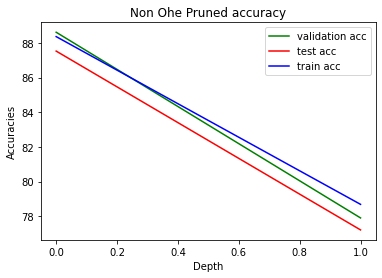

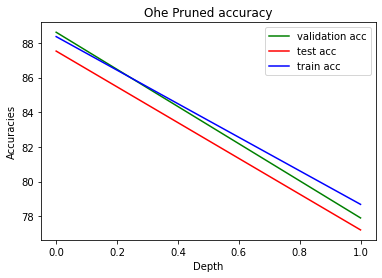

In [37]:
# part = 'b'
if part == 'b':
    _ = d_tree.prune_tree(std_tree_root, std_vali_data[:])
    _ = d_tree.prune_tree(ohe_tree_root, ohe_vali_data[:])
    
    print('Pruned Accuracy for Trained')
    _, std_pruned_train_acc = d_tree.predict(std_tree_root, std_train_data[:], consider_pruning=True)
    print('\tFor standard data :',std_pruned_train_acc)

    _, ohe_pruned_train_acc = d_tree.predict(ohe_tree_root, ohe_train_data[:], consider_pruning=True)
    print('\tFor OHE data      :',ohe_pruned_train_acc)
    
    print('Pruned Accuracy for Test')
    _, std_pruned_test_acc = d_tree.predict(std_tree_root, std_test_data[:], consider_pruning=True)
    print('\tFor standard data :',std_pruned_test_acc)

    _, ohe_pruned_test_acc = d_tree.predict(ohe_tree_root, ohe_test_data[:], consider_pruning=True)
    print('\tFor OHE data      :',ohe_pruned_test_acc)
    
    print('Pruned Accuracy for Validation')
    _, std_pruned_vali_acc = d_tree.predict(std_tree_root, std_vali_data[:], consider_pruning=True)
    print('\tFor standard data :',std_pruned_vali_acc)
    
    _, ohe_pruned_vali_acc = d_tree.predict(ohe_tree_root, ohe_vali_data[:], consider_pruning=True)
    print('\tFor OHE data      :',ohe_pruned_vali_acc)

    fig = plt.figure()
    plt.plot(std_pruned_vali_acc, '-g', label = 'validation acc')
    plt.plot(std_pruned_test_acc, '-r', label = 'test acc')
    plt.plot(std_pruned_train_acc, '-b', label = 'train acc')
    plt.title("Non Ohe Pruned accuracy")
    plt.xlabel("Depth")
    plt.ylabel("Accuracies")
    plt.legend()
    #plt.show()
    fig.savefig("Non_ohe_pruned_accuracy_all.png")

    fig = plt.figure()
    plt.plot(ohe_pruned_vali_acc, '-g', label = 'validation acc')
    plt.plot(ohe_pruned_test_acc, '-r', label = 'test acc')
    plt.plot(ohe_pruned_train_acc, '-b', label = 'train acc')
    plt.title("Ohe Pruned accuracy")
    plt.xlabel("Depth")
    plt.ylabel("Accuracies")
    plt.legend()
    #plt.show()
    fig.savefig("Ohe_pruned_accuracy_all.png")
    

Pruned Accuracy for Test
	For standard data : [87.52488387524883, 87.52488387524883, 88.80778588807786, 88.98473788984738, 88.69719088697191, 89.27228489272285, 88.85202388852024, 89.00685689006856, 88.36540588365406, 88.14421588144216, 88.07785888077859, 88.12209688122097, 88.14421588144216, 88.09997788099977, 88.07785888077859, 88.07785888077859]


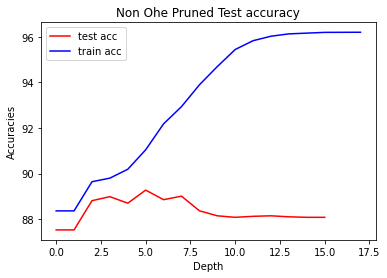

	For OHE data      : [87.52488387524883, 87.52488387524883, 88.80778588807786, 88.82990488829905, 88.80778588807786, 89.33864189338642, 89.47135589471355, 89.27228489272285, 89.18380889183808, 89.05109489051095, 89.07321389073213, 89.09533289095333, 89.20592789205928, 89.02897589028976, 88.89626188896261, 88.940499889405, 88.69719088697191, 88.52023888520239, 88.74142888741429, 88.63083388630834, 88.56447688564477, 88.47600088476001, 88.45388188453882, 88.34328688343287, 88.45388188453882, 88.34328688343287, 88.54235788542358, 88.34328688343287, 88.38752488387524, 88.38752488387524, 88.40964388409644, 88.43176288431764, 88.43176288431764, 88.43176288431764, 88.43176288431764]


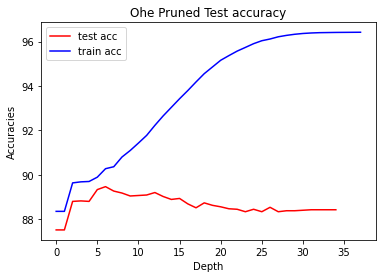

In [82]:
# print('Pruned Accuracy for Test')
# _, std_pruned_test_acc = d_tree.predict(std_tree_root, std_test_data[:], consider_pruning=True)
# print('\tFor standard data :',std_pruned_test_acc)

# fig = plt.figure()
# plt.plot(std_pruned_test_acc, '-r', label = 'test acc')
# plt.plot(std_pruned_train_acc, '-b', label = 'train acc')
# plt.title("Non Ohe Pruned Test accuracy")
# plt.xlabel("Depth")
# plt.ylabel("Accuracies")
# plt.legend()
# plt.show()
# #fig.savefig("Non_ohe_pruned_test_accuracy.png")

# _, ohe_pruned_test_acc = d_tree.predict(ohe_tree_root, ohe_test_data[:], consider_pruning=True)
# print('\tFor OHE data      :',ohe_pruned_test_acc)

# fig = plt.figure()
# plt.plot(ohe_pruned_test_acc, '-r', label = 'test acc')
# plt.plot(ohe_pruned_train_acc, '-b', label = 'train acc')
# plt.title("Ohe Pruned Test accuracy")
# plt.xlabel("Depth")
# plt.ylabel("Accuracies")
# plt.legend()
# plt.show()
# #fig.savefig("Ohe_pruned_test_accuracy.png")

Pruned Accuracy for Validation
	For standard data : [88.61123396727112, 88.61123396727112, 89.16408668730651, 89.20831490490933, 89.4515701017249, 89.16408668730651, 89.89385227775321, 90.24767801857585, 90.07076514816453, 90.51304732419284, 90.84475895621406, 91.0216718266254, 91.15435647943387, 91.15435647943387, 91.17647058823529]


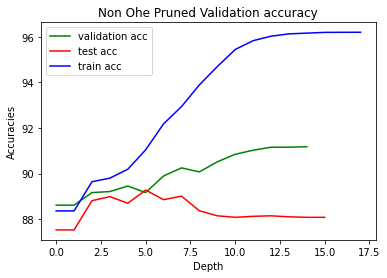

	For OHE data      : [88.61123396727112, 88.61123396727112, 89.16408668730651, 89.27465723131358, 89.25254312251217, 89.0092879256966, 89.29677134011499, 89.47368421052632, 90.0265369305617, 89.69482529854047, 89.4515701017249, 89.80539584254754, 89.91596638655462, 89.98230871295887, 90.13710747456878, 90.22556390977444, 90.0265369305617, 90.24767801857585, 89.91596638655462, 90.20344980097302, 90.35824856258293, 90.40247678018576, 90.55727554179566, 90.49093321539142, 90.62361786819991, 90.6015037593985, 90.66784608580274, 90.57938965059708, 90.6015037593985, 90.62361786819991, 90.64573197700133, 90.64573197700133, 90.64573197700133]


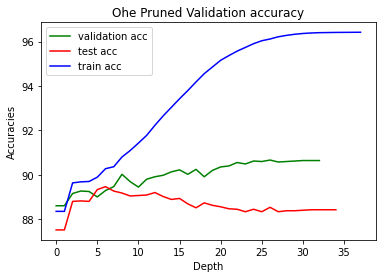

In [83]:
# print('Pruned Accuracy for Validation')
# _, std_pruned_vali_acc = d_tree.predict(std_tree_root, std_vali_data[:], consider_pruning=True)
# print('\tFor standard data :',std_pruned_vali_acc)

# fig = plt.figure()
# plt.plot(std_pruned_vali_acc, '-g', label = 'validation acc')
# plt.plot(std_pruned_test_acc, '-r', label = 'test acc')
# plt.plot(std_pruned_train_acc, '-b', label = 'train acc')
# plt.title("Non Ohe Pruned Validation accuracy")
# plt.xlabel("Depth")
# plt.ylabel("Accuracies")
# plt.legend()
# plt.show()
# #fig.savefig("Non_ohe_pruned_validation_accuracy.png")

# _, ohe_pruned_vali_acc = d_tree.predict(ohe_tree_root, ohe_vali_data[:], consider_pruning=True)
# print('\tFor OHE data      :',ohe_pruned_vali_acc)

# fig = plt.figure()
# plt.plot(ohe_pruned_vali_acc, '-g', label = 'validation acc')
# plt.plot(ohe_pruned_test_acc, '-r', label = 'test acc')
# plt.plot(ohe_pruned_train_acc, '-b', label = 'train acc')
# plt.title("Ohe Pruned Validation accuracy")
# plt.xlabel("Depth")
# plt.ylabel("Accuracies")
# plt.legend()
# plt.show()
# #fig.savefig("Ohe_pruned_validation_accuracy.png")

### For Part c--

In [38]:
n_estimators = np.array(range(50, 451, 100))
#print('n_ests            :',n_estimators)
max_features = np.array(range(1, 11,2))/10
#print('max features      :',max_features)
min_samples_split = np.array(range(2,12,2))
#print('min samples split :',min_samples_split)

In [44]:
# %%time
# # also try with gini (using entropy)
# d = 50
# n_est = 250
# min_s_s = 6
# max_f = 0.5
# rfc = RandomForestClassifier(n_estimators=n_est ,max_depth=d,min_samples_split=min_s_s, max_features = max_f)
# cols_not_y = ohe_train_data.columns[:-1]
# # print(cols_not_y)
# X = ohe_train_data.loc[:,cols_not_y]
# Y = ohe_train_data['y'] == 'yes'
# print(X.shape, Y.shape)
# rfc.fit(X,Y)

(36168, 94) (36168,)
CPU times: user 35 s, sys: 26.6 ms, total: 35 s
Wall time: 35 s


RandomForestClassifier(max_depth=50, max_features=0.5, min_samples_split=6,
                       n_estimators=250)

In [45]:
# Y = ohe_vali_data['y'] == 'yes'
# predict = rfc.predict(ohe_vali_data.loc[:, cols_not_y])
# acc = accuracy_score(np.array(Y), np.array(predict, dtype=int))
# print(acc)

0.9082264484741265


In [40]:
def part_c_random_forest():
    cols_not_y = ohe_train_data.columns[:-1]
    X_train = ohe_train_data.loc[:, cols_not_y]
    Y_train = ohe_train_data['y'] == 'yes'
    X_test  = ohe_test_data.loc[:, cols_not_y]
    Y_test  = ohe_test_data['y'] == 'yes'
    X_vali  = ohe_vali_data.loc[:, cols_not_y]
    Y_vali  = ohe_vali_data['y'] == 'yes'
    
    d = 50
    n_estimators = np.array(range(50, 451, 100))
    max_features = np.array(range(1, 11,2))/10
    min_samples_split = np.array(range(2,12,2))
    # print('n_ests            :',n_estimators)
    # print('max features      :',max_features)
    # print('min samples split :',min_samples_split)
    best_n_est    = 150
    best_max_f    = 0.5
    best_min_s_s  = 10
    best_accuracy = 0
    best_model    = None
    
    itr = 0
    for n_est in tqdm_notebook(n_estimators, total = len(n_estimators), unit = 'n_est'):
        for max_f in tqdm_notebook(max_features, total = len(max_features), unit = 'max_f'):
            for min_s_s in tqdm_notebook(min_samples_split, total = len(min_samples_split), unit = 'min_s_s'):
                rfc = RandomForestClassifier(n_estimators=n_est ,max_depth=d,min_samples_split=min_s_s, max_features = max_f, random_state=0)
                rfc.fit(X_train,Y_train)
                
                #predict_train = rfc.predict(X_train)
                #predict_test  = rfc.predict(X_test)
                predict_vali  = rfc.predict(X_vali)
                
                #train_acc = accuracy_score(np.array(Y_train), np.array(predict_train, dtype=int))
                #test_acc  = accuracy_score(np.array(Y_test) , np.array(predict_test , dtype=int))
                vali_acc  = accuracy_score(np.array(Y_vali) , np.array(predict_vali , dtype=int))
                
                if best_accuracy < vali_acc:
                    best_model = rfc
                    best_accuracy = vali_acc
                    best_n_est = n_est
                    best_max_f = max_f
                    best_min_s_s = min_s_s
                    
    predict_train = best_model.predict(X_train)
    predict_test  = best_model.predict(X_test)
    predict_vali  = best_model.predict(X_vali)

    train_acc = accuracy_score(np.array(Y_train), np.array(predict_train, dtype=int))
    test_acc  = accuracy_score(np.array(Y_test) , np.array(predict_test , dtype=int))
    vali_acc  = accuracy_score(np.array(Y_vali) , np.array(predict_vali , dtype=int))
    
    print('Best n_estimator     :', best_n_est)
    print('Best max_feature     :', best_max_f)
    print('Best min_sample_split:', best_min_s_s)
    print()
    print('Train Accuracy     :', train_acc)
    print('Test Accuracy      :', test_acc)
    print('Validation Accuracy:', vali_acc)
    
    return best_model
    

In [41]:
part = 'c'
if part == 'c':
    rfc = part_c_random_forest()

  0%|          | 0/5 [00:00<?, ?n_est/s]

  0%|          | 0/5 [00:00<?, ?max_f/s]

  0%|          | 0/5 [00:00<?, ?min_s_s/s]

  0%|          | 0/5 [00:00<?, ?min_s_s/s]

KeyboardInterrupt: 

In [42]:
def part_d_param_senitivity(best_n_est=50, best_max_f = 0.3, best_min_s_s = 4):
    d = 50
    cols_not_y = ohe_train_data.columns[:-1]
    X_train = ohe_train_data.loc[:, cols_not_y]
    Y_train = ohe_train_data['y'] == 'yes'
    X_test  = ohe_test_data.loc[:, cols_not_y]
    Y_test  = ohe_test_data['y'] == 'yes'
    X_vali  = ohe_vali_data.loc[:, cols_not_y]
    Y_vali  = ohe_vali_data['y'] == 'yes'
    
    n_estimators = np.array(range(50, 451, 100))
    max_features = np.array(range(1, 11,2))/10
    min_samples_split = np.array(range(2,12,2))
    
    accuracy_for_n_est = []
    for n_est in tqdm_notebook(n_estimators):
        rfc = RandomForestClassifier(n_estimators=n_est ,max_depth=d,min_samples_split=best_min_s_s, max_features = best_max_f, random_state=0)
        rfc.fit(X_train,Y_train)

        #predict_train = rfc.predict(X_train)
        #predict_test  = rfc.predict(X_test)
        predict_vali  = rfc.predict(X_vali)

        #train_acc = accuracy_score(np.array(Y_train), np.array(predict_train, dtype=int))
        #test_acc  = accuracy_score(np.array(Y_test) , np.array(predict_test , dtype=int))
        vali_acc  = accuracy_score(np.array(Y_vali) , np.array(predict_vali , dtype=int))
        accuracy_for_n_est.append(vali_acc)
        
    fig = plt.figure()
    plt.plot(n_estimators, accuracy_for_n_est)
    plt.title("Sensitivity for n_estimators")
    plt.xlabel("n_estimators")
    plt.ylabel("Accuracies")
    #plt.show()
    fig.savefig("Sensitivity_for_n_estimators.png")
    
    accuracy_for_max_f = []
    for max_f in tqdm_notebook(max_features):
        rfc = RandomForestClassifier(n_estimators=best_n_est ,max_depth=d,min_samples_split=best_min_s_s, max_features = max_f, random_state=0)
        rfc.fit(X_train,Y_train)

        #predict_train = rfc.predict(X_train)
        #predict_test  = rfc.predict(X_test)
        predict_vali  = rfc.predict(X_vali)

        #train_acc = accuracy_score(np.array(Y_train), np.array(predict_train, dtype=int))
        #test_acc  = accuracy_score(np.array(Y_test) , np.array(predict_test , dtype=int))
        vali_acc  = accuracy_score(np.array(Y_vali) , np.array(predict_vali , dtype=int))
        accuracy_for_max_f.append(vali_acc)
        
    fig = plt.figure()
    plt.plot(max_features, accuracy_for_max_f)
    plt.title("Sensitivity for Max_features")
    plt.xlabel("max_features")
    plt.ylabel("Accuracies")
    plt.savefig('Sensitivity_for_Max_features.png')
    #plt.show()
    
    accuracy_for_min_s_s = []
    for min_s_s in tqdm_notebook(min_samples_split):
        rfc = RandomForestClassifier(n_estimators=best_n_est ,max_depth=d,min_samples_split=min_s_s, max_features = best_max_f, random_state=0)
        rfc.fit(X_train,Y_train)

        #predict_train = rfc.predict(X_train)
        #predict_test  = rfc.predict(X_test)
        predict_vali  = rfc.predict(X_vali)

        #train_acc = accuracy_score(np.array(Y_train), np.array(predict_train, dtype=int))
        #test_acc  = accuracy_score(np.array(Y_test) , np.array(predict_test , dtype=int))
        vali_acc  = accuracy_score(np.array(Y_vali) , np.array(predict_vali , dtype=int))
        accuracy_for_min_s_s.append(vali_acc)
    
    fig = plt.figure()
    plt.plot(min_samples_split, accuracy_for_min_s_s)
    plt.title("Sensitivity for Min sample split")
    plt.xlabel("Min sample split")
    plt.ylabel("Accuracies")
    plt.savefig('Sensitivity_for_Min_sample_split.png')
    #plt.show()
    
    return


In [43]:
if part == 'd':
    part_d_param_senitivity()

  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 